In [1]:
import torch
from transformers.models.gpt2 import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
import transformers
from transformers import AutoTokenizer
from dataset import GPT2Dataset, GPT2DatasetReplace, TestDataset
from tqdm import tqdm
import numpy as np
import json
import re
import os

/home/huyi/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:1"
task = "mod_add_ood_8"

In [3]:
print("loading model...")
model = GPT2LMHeadModel.from_pretrained(f"save_model/{task}/model_90").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("pretrained_models/gpt2")
print("done!")

loading model...
done!


In [4]:
file_path=f'datasets/{task}/test.json'
with open(file_path, "r") as f:
    test_set = json.load(f)

In [5]:
def extract_answer(s: str):
    return re.findall(r'[0-9]+\.?[0-9]*', s)[-1]

def generate(test_set, model, temperature=1, generation_num=10):
    '''
    return a list of dict [{
        "question":, "a":, "b":, "answers":[], "generated_answers":[], "acc":
    }]
    '''
    generated_samples = []
    for sample in tqdm(test_set):
        query = tokenizer(sample["question"], return_tensors="pt").input_ids
        answer = sample["answers"][0]
        generated_answers = []
        correct = 0
        all = 0
        for _ in range(generation_num):
            outputs = model.generate(query.to(device), max_length=50, do_sample=True, temperature=temperature, pad_token_id=50257)
            generated_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
            generated_answer = extract_answer(generated_answer)
            generated_answers.append(generated_answer)
            all += 1
            if generated_answer == answer:
                correct += 1
        sample["generated_answers"] = generated_answers
        sample["accuracy"] = correct/all
        generated_samples.append(sample)
    return generated_samples
            
        
        

In [6]:
results = generate(test_set, model)

100%|██████████| 1681/1681 [04:55<00:00,  5.69it/s]


In [7]:
a_range = b_range = int(np.sqrt(len(test_set)))
data = np.zeros((a_range, b_range))
a_start = int(test_set[0]["a"])
b_start = int(test_set[0]["b"])
for result in results:
    a = int(result["a"])
    b = int(result["b"])
    data[a-a_start][b-b_start] = result["accuracy"]

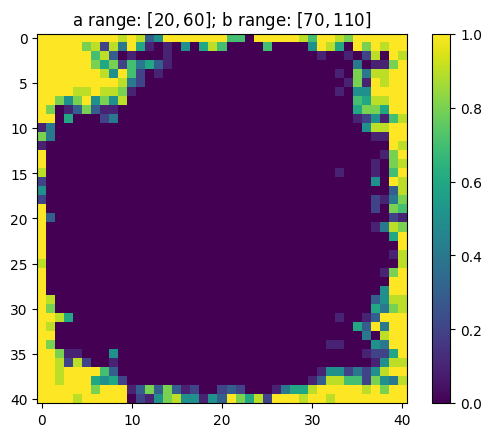

In [9]:
import matplotlib.pyplot as plt

plt.title("a range: $[20,60]$; b range: $[70,110]$")
plt.imshow(data)
plt.colorbar()